<a href="https://colab.research.google.com/github/rizkadahliard/Classification_Patient_Covid19_SouthKorea/blob/main/BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Koneksi ke Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#IMPORT MODULE

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot
from sklearn import metrics
import matplotlib.pyplot as plt; plt.rcdefaults()

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from lightgbm import LGBMClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score , confusion_matrix,f1_score, roc_auc_score,precision_score, recall_score,roc_curve

from datetime import date

## Data Patien Info

In [ ]:
patien_info = pd.read_csv('drive/MyDrive/dataset/PatientInfo.csv')

In [ ]:
print(patien_info.shape)
patien_info.head()

(5165, 13)


,patient_id,sex,age,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50.0,Seoul,Gangseo-gu,overseas inflow,NaN,75,1/22/2020,1/23/2020,2/5/2020,NaN,released
1,1000000002,male,30.0,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,1/30/2020,3/2/2020,NaN,released
2,1000000003,male,50.0,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,1/30/2020,2/19/2020,NaN,released
3,1000000004,male,20.0,Seoul,Mapo-gu,overseas inflow,NaN,9,1/26/2020,1/30/2020,2/15/2020,NaN,released
4,1000000005,female,20.0,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,1/31/2020,2/24/2020,NaN,released


In [ ]:
patien_info.rename(columns= {'confirmed_date' :'date'}, inplace=True) #mengubah nama column confirmed_date menjadi date
patien_info.age = patien_info.age.fillna(0) #mengubah bagian kosong pada kolom age menjadi 0
patien_info.age= patien_info.age.astype('int64') #mengubah tipe data kolom age
print(patien_info.shape)
patien_info.head()#menampilkan data patien_info

(5165, 13)


,patient_id,sex,age,province,city,infection_case,infected_by,contact_number,symptom_onset_date,date,released_date,deceased_date,state
0,1000000001,male,50,Seoul,Gangseo-gu,overseas inflow,NaN,75,1/22/2020,1/23/2020,2/5/2020,NaN,released
1,1000000002,male,30,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,1/30/2020,3/2/2020,NaN,released
2,1000000003,male,50,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,1/30/2020,2/19/2020,NaN,released
3,1000000004,male,20,Seoul,Mapo-gu,overseas inflow,NaN,9,1/26/2020,1/30/2020,2/15/2020,NaN,released
4,1000000005,female,20,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,1/31/2020,2/24/2020,NaN,released


# DATA PREPARASI

In [ ]:
pip install plotly_express==0.4.0

In [ ]:
def null_analysis(patien_info):
  null_cnt = patien_info.isnull().sum() # calculate null counts
  null_cnt = null_cnt[null_cnt!=0] # remove non-null cols
  null_percent = null_cnt / len(patien_info) * 100 # calculate null percentages
  null_table = pd.concat([pd.DataFrame(null_cnt), pd.DataFrame(null_percent)], axis=1)
  null_table.columns = ['counts', 'percentage']
  null_table.sort_values('counts', ascending=False, inplace=True)
  return null_table

# visualise null table
import plotly_express as px
null_table = null_analysis(patien_info)
px.bar(null_table.reset_index(), x='index', y='percentage', text='counts', height=500)

In [ ]:
patien_info.drop(['deceased_date','released_date'], inplace=True, axis=1)

## Distribusi Label

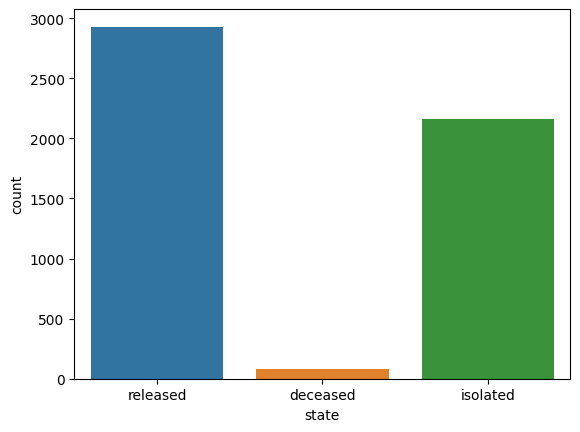

In [ ]:
sns.countplot(x='state', data=patien_info);pyplot.show()

## REPLACE MISSING VALUE

In [ ]:
patien_info.describe()

,patient_id,age
count,5.165000e+03,5165.000000
mean,2.863635e+09,29.581801
std,2.074211e+09,24.860169
min,1.000000e+09,0.000000
25%,1.000001e+09,0.000000
50%,2.000000e+09,30.000000
75%,6.001000e+09,50.000000
max,7.000000e+09,100.000000


In [ ]:
patien_info.min()

patient_id    1000000001
age                    0
province           Busan
state           deceased
dtype: object

In [ ]:
from numpy import nan 
patien_info[['symptom_onset_date']] = patien_info[['symptom_onset_date']].replace(" ", nan)

In [ ]:
patien_info['symptom_onset_date'] = patien_info['symptom_onset_date'].replace(np.nan, '1/1/2020')

In [ ]:
patien_info

,patient_id,sex,age,province,city,infection_case,infected_by,contact_number,symptom_onset_date,date,state
0,1000000001,male,50,Seoul,Gangseo-gu,overseas inflow,NaN,75,1/22/2020,1/23/2020,released
1,1000000002,male,30,Seoul,Jungnang-gu,overseas inflow,NaN,31,1/1/2020,1/30/2020,released
2,1000000003,male,50,Seoul,Jongno-gu,contact with patient,2002000001,17,1/1/2020,1/30/2020,released
3,1000000004,male,20,Seoul,Mapo-gu,overseas inflow,NaN,9,1/26/2020,1/30/2020,released
4,1000000005,female,20,Seoul,Seongbuk-gu,contact with patient,1000000002,2,1/1/2020,1/31/2020,released
...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30,Jeju-do,Jeju-do,overseas inflow,NaN,25,1/1/2020,5/30/2020,released
5161,7000000016,NaN,0,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,1/1/2020,6/16/2020,released
5162,7000000017,NaN,0,Jeju-do,Jeju-do,overseas inflow,NaN,72,1/1/2020,6/18/2020,isolated
5163,7000000018,NaN,0,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,1/1/2020,6/18/2020,isolated


In [ ]:
patien_info['sex'].replace({'male' : 0}, inplace=True)
patien_info['sex'].replace({'female' : 1}, inplace=True)
patien_info['sex'] = patien_info['sex'].replace(np.nan, -1)
patien_info['infection_case'] = patien_info['infection_case'].replace(np.nan, 2)
patien_info['infected_by'] = patien_info['infected_by'].replace(np.nan, -1)
patien_info['contact_number'] = patien_info['contact_number'].replace(np.nan, -1)
patien_info['symptom_onset_date'] = pd.to_datetime(patien_info.symptom_onset_date, format='%m/%d/%Y')
patien_info['date'] = pd.to_datetime(patien_info.date, format='%m/%d/%Y')
for col_name in patien_info.columns:
    if(patien_info[col_name].dtype == 'object'):
        patien_info[col_name]= patien_info[col_name].astype('category')
        patien_info[col_name] = patien_info[col_name].cat.codes
patien_info

,patient_id,sex,age,province,city,infection_case,infected_by,contact_number,symptom_onset_date,date,state
0,1000000001,0.0,50,15,39,51,0,80,2020-01-22,2020-01-23,2
1,1000000002,0.0,30,15,93,51,0,43,2020-01-01,2020-01-30,2
2,1000000003,0.0,50,15,91,47,475,23,2020-01-01,2020-01-30,2
3,1000000004,0.0,20,15,95,51,0,87,2020-01-26,2020-01-30,2
4,1000000005,1.0,20,15,124,47,1,28,2020-01-01,2020-01-31,2
...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,1.0,30,11,86,51,0,34,2020-01-01,2020-05-30,2
5161,7000000016,-1.0,0,11,86,51,0,0,2020-01-01,2020-06-16,2
5162,7000000017,-1.0,0,11,86,51,0,78,2020-01-01,2020-06-18,1
5163,7000000018,-1.0,0,11,86,51,0,0,2020-01-01,2020-06-18,1


## Label Endcoder

In [ ]:
patien_info['days']  = patien_info.date - patien_info.symptom_onset_date
patien_info.drop(['symptom_onset_date','date'], inplace=True, axis=1)

patien_info

,patient_id,sex,age,province,city,infection_case,infected_by,contact_number,state,days
0,1000000001,0.0,50,15,39,51,0,80,2,1 days
1,1000000002,0.0,30,15,93,51,0,43,2,29 days
2,1000000003,0.0,50,15,91,47,475,23,2,29 days
3,1000000004,0.0,20,15,95,51,0,87,2,4 days
4,1000000005,1.0,20,15,124,47,1,28,2,30 days
...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,1.0,30,11,86,51,0,34,2,150 days
5161,7000000016,-1.0,0,11,86,51,0,0,2,167 days
5162,7000000017,-1.0,0,11,86,51,0,78,1,169 days
5163,7000000018,-1.0,0,11,86,51,0,0,1,169 days


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
patien_info['sex']=le.fit_transform(patien_info['sex'])
patien_info['age']=le.fit_transform(patien_info['age'])
patien_info['city']=le.fit_transform(patien_info['city'])
patien_info['infection_case']=le.fit_transform(patien_info['infection_case'])
patien_info['infected_by']=le.fit_transform(patien_info['infected_by'])
patien_info['contact_number']=le.fit_transform(patien_info['contact_number'])
patien_info

,patient_id,sex,age,province,city,infection_case,infected_by,contact_number,state,days
0,1000000001,1,5,15,40,51,0,80,2,1 days
1,1000000002,1,3,15,94,51,0,43,2,29 days
2,1000000003,1,5,15,92,47,475,23,2,29 days
3,1000000004,1,2,15,96,51,0,87,2,4 days
4,1000000005,2,2,15,125,47,1,28,2,30 days
...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,2,3,11,87,51,0,34,2,150 days
5161,7000000016,0,0,11,87,51,0,0,2,167 days
5162,7000000017,0,0,11,87,51,0,78,1,169 days
5163,7000000018,0,0,11,87,51,0,0,1,169 days


In [ ]:
patien_info.columns

Index(['patient_id', 'sex', 'age', 'province', 'city', 'infection_case',
       'infected_by', 'contact_number', 'state', 'days'],
      dtype='object')

In [ ]:
fiture_cols = ['sex', 'age', 'city', 'infection_case',
       'infected_by', 'contact_number']
X = patien_info[fiture_cols]
Y = patien_info.state

## Cross Validation

In [ ]:
test_size = 0.2
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Model

# Decision Tree

              precision    recall  f1-score   support

           0       0.31      0.50      0.38        10
           1       0.83      0.88      0.85       435
           2       0.90      0.86      0.88       588

    accuracy                           0.86      1033
   macro avg       0.68      0.74      0.70      1033
weighted avg       0.87      0.86      0.86      1033

[[  5   1   4]
 [  2 381  52]
 [  9  76 503]]
Accuracy Decision Tree: 82.09136532057595
ROC AUC score dt: 90.61714790065307
Recall of dt is:  86.06001936108422
Precision of dt is: 86.06001936108422
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


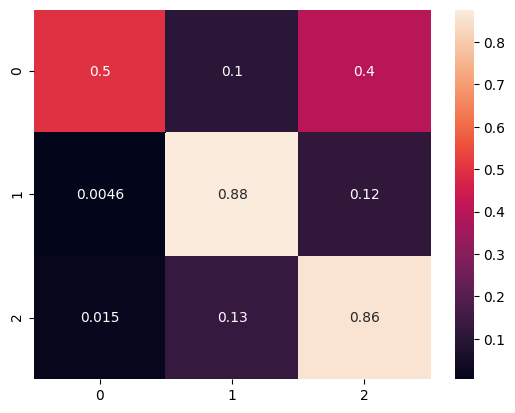

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
predicted = dt.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

scoring = 'accuracy'
akurasi_dt = cross_val_score(dt, X_test, Y_test, cv=seed, scoring=scoring) *100

from sklearn.metrics import roc_auc_score

print("Accuracy Decision Tree: {}".format((akurasi_dt.mean()))) 
auc_dt = roc_auc_score(Y_test, dt.predict_proba(X_test), multi_class='ovo', average='weighted') *100
print('ROC AUC score dt:', auc_dt)

recall_dt=recall_score(Y_test,predicted, average='weighted')*100
print("Recall of dt is: ",recall_dt)
prec_dt=precision_score(Y_test,predicted, average='weighted')*100
print("Precision of dt is:",prec_dt)

print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))

# Naive Bayes

              precision    recall  f1-score   support

           0       0.17      0.70      0.28        10
           1       0.62      0.61      0.61       435
           2       0.72      0.69      0.70       588

    accuracy                           0.66      1033
   macro avg       0.50      0.67      0.53      1033
weighted avg       0.67      0.66      0.66      1033

[[  7   0   3]
 [ 13 265 157]
 [ 20 162 406]]
Akurasi Naive Bayes: 29.806763285024157
ROC AUC score Naive Bayes: 78.78516094156727
Recall of Naive Bayes is:  65.63407550822846
Precision of Naive Bayes is: 65.63407550822846
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


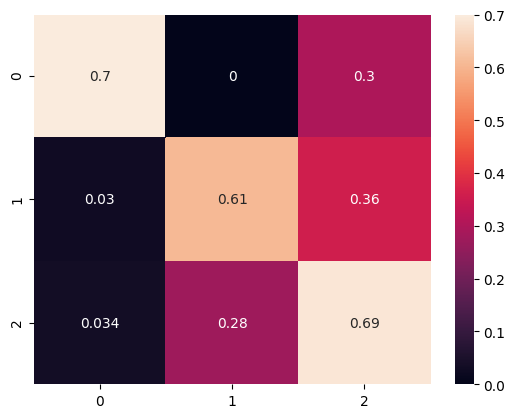

In [ ]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
predicted = nb.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

scoring = 'accuracy'
akurasi_nb = cross_val_score(nb, X_test, Y_test, cv=seed, scoring=scoring) *100

from sklearn.metrics import roc_auc_score

print("Akurasi Naive Bayes: {}".format((akurasi_nb.mean()))) 
auc_nb = roc_auc_score(Y_test, nb.predict_proba(X_test), multi_class='ovo', average='weighted') *100
print('ROC AUC score Naive Bayes:', auc_nb)
recall_nb=recall_score(Y_test,predicted, average='weighted')*100
print("Recall of Naive Bayes is: ",recall_nb)
prec_nb=precision_score(Y_test,predicted, average='weighted')*100
print("Precision of Naive Bayes is:",prec_nb)
print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))

# Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.61      0.50      0.55       435
           2       0.66      0.77      0.71       588

    accuracy                           0.65      1033
   macro avg       0.43      0.42      0.42      1033
weighted avg       0.64      0.65      0.64      1033

[[  0   0  10]
 [  0 216 219]
 [  0 137 451]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Akurasi Logistic Regresion: 67.47619717649266
ROC AUC score Logistic Regresion: 71.53751840222687
Recall of Logistic Regresion is:  64.56921587608906
Precision of Logistic Regresion is: 64.56921587608906
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


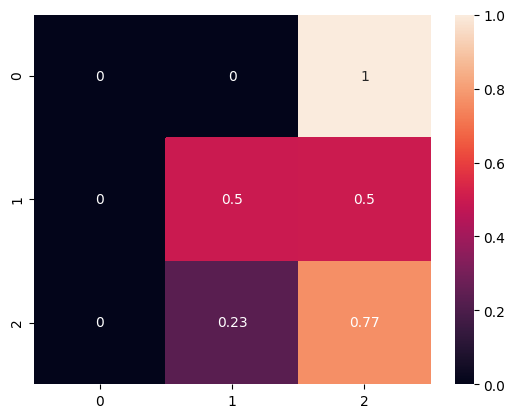

In [ ]:
log = LogisticRegression()
log.fit(X_train, Y_train)
predicted = log.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

scoring = 'accuracy'
akurasi_log = cross_val_score(log, X_test, Y_test, cv=seed, scoring=scoring) *100

from sklearn.metrics import roc_auc_score

print("Akurasi Logistic Regresion: {}".format((akurasi_log.mean()))) 
auc_log = roc_auc_score(Y_test, log.predict_proba(X_test), multi_class='ovo', average='weighted') *100
print('ROC AUC score Logistic Regresion:', auc_log)
recall_log=recall_score(Y_test,predicted, average='weighted')*100
print("Recall of Logistic Regresion is: ",recall_log)
prec_log=precision_score(Y_test,predicted, average='weighted') *100
print("Precision of Logistic Regresion is:",prec_log)
print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))

# Random Forest

              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.84      0.83      0.84       435
           2       0.87      0.88      0.87       588

    accuracy                           0.85      1033
   macro avg       0.72      0.74      0.73      1033
weighted avg       0.85      0.85      0.85      1033

[[  5   1   4]
 [  1 362  72]
 [  5  68 515]]
Akurasi Random Forest: 80.44510107405844
ROC AUC score Random Forest: 92.99940629187549
Recall of Random Forest is:  85.38238141335914
Precision of Random Forest is: 85.38238141335914
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


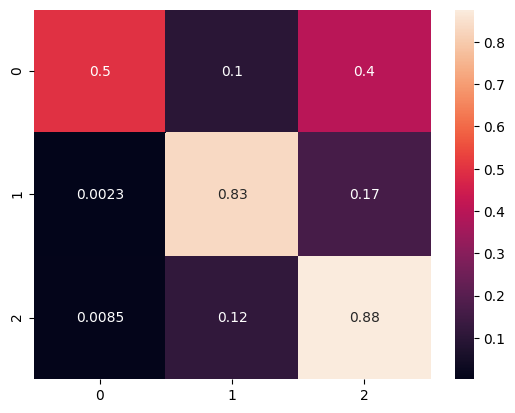

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
predicted = rf.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

scoring = 'accuracy'
akurasi_rf = cross_val_score(rf, X_test, Y_test, cv=seed, scoring=scoring) *100

from sklearn.metrics import roc_auc_score

print("Akurasi Random Forest: {}".format((akurasi_rf.mean()))) 
auc_rf = roc_auc_score(Y_test, rf.predict_proba(X_test), multi_class='ovo', average='weighted') *100
print('ROC AUC score Random Forest:', auc_rf)
recall_rf=recall_score(Y_test,predicted, average='weighted')*100
print("Recall of Random Forest is: ",recall_rf)
prec_rf=precision_score(Y_test,predicted, average='weighted')*100
print("Precision of Random Forest is:",prec_rf)
print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))


# KNN

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.85      0.80      0.82       435
           2       0.85      0.89      0.87       588

    accuracy                           0.85      1033
   macro avg       0.75      0.73      0.74      1033
weighted avg       0.85      0.85      0.85      1033

[[  5   0   5]
 [  1 346  88]
 [  3  62 523]]

Akurasi KNN: 76.18732704844987
ROC AUC score KNN: 91.78479857410133
Recall of KNN is:  84.6079380445305
Precision of KNN is: 84.6079380445305
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


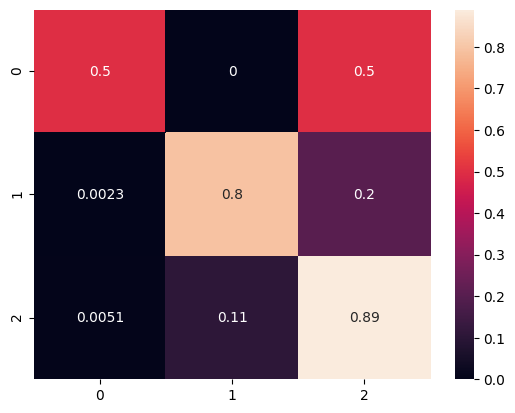

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predicted = knn.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

scoring = 'accuracy'
akurasi_knn = cross_val_score(knn, X_test, Y_test, cv=seed, scoring=scoring) *100
print("\nAkurasi KNN: {}".format((akurasi_knn.mean()))) 
auc_knn = roc_auc_score(Y_test, knn.predict_proba(X_test), multi_class='ovo', average='weighted') *100
print('ROC AUC score KNN:', auc_knn)
recall_knn=recall_score(Y_test,predicted, average='weighted')*100
print("Recall of KNN is: ",recall_knn)
prec_knn=precision_score(Y_test,predicted, average='weighted')*100
print("Precision of KNN is:",prec_knn)
print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))

# Light Gradient Boost

              precision    recall  f1-score   support

           0       0.42      0.50      0.45        10
           1       0.87      0.84      0.86       435
           2       0.89      0.90      0.89       588

    accuracy                           0.87      1033
   macro avg       0.72      0.75      0.74      1033
weighted avg       0.87      0.87      0.87      1033

[[  5   1   4]
 [  3 367  65]
 [  4  53 531]]
Accuracy Light Gradient Boosting: 82.6720135078092
ROC AUC score LGBM: 95.4218248537189
Recall of LGBM is:  87.41529525653436
Precision of LGBM is: 87.41529525653436
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


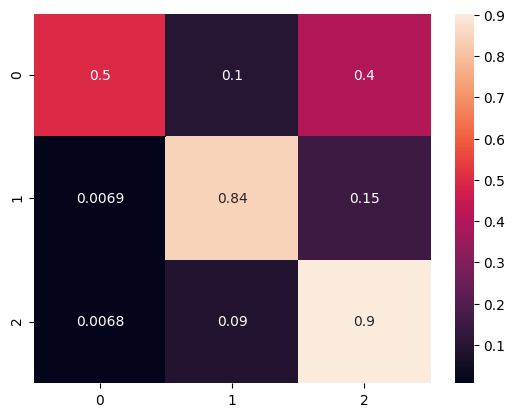

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, Y_train)
predicted = lgbm.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

scoring = 'accuracy'
akurasi_lgbm = cross_val_score(lgbm, X_test, Y_test, cv=seed, scoring=scoring) *100

from sklearn.metrics import roc_auc_score

print("Accuracy Light Gradient Boosting: {}".format((akurasi_lgbm.mean()))) 
auc_lgbm = roc_auc_score(Y_test, lgbm.predict_proba(X_test), multi_class='ovo', average='weighted') *100
print('ROC AUC score LGBM:', auc_lgbm)

recall_lgbm=recall_score(Y_test,predicted, average='weighted')*100
print("Recall of LGBM is: ",recall_lgbm)
prec_lgbm=precision_score(Y_test,predicted, average='weighted')*100
print("Precision of LGBM is:",prec_lgbm)

print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))

In [ ]:
lgbm.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# HASIL AKURASI

In [ ]:
algos=["Decision Tree","Naive Bayes","Logistic Regression","Random Forest","KNN","Light Gradient Boost"]
acc=[akurasi_dt.mean(), akurasi_nb.mean(), akurasi_log.mean(),akurasi_rf.mean(),akurasi_knn.mean(),akurasi_lgbm.mean()]
auc=[auc_dt, auc_nb, auc_log,  auc_rf, auc_knn, auc_lgbm]
recall=[recall_dt, recall_nb, recall_log,  recall_rf, recall_knn, recall_lgbm]
prec=[prec_dt, prec_nb, prec_log,  prec_rf, prec_knn, prec_lgbm]

comp={"Algorithms":algos,"Accuracies":acc,"AUC":auc,"Recall":recall,"Precision":prec}
compdf=pd.DataFrame(comp)
display(compdf.sort_values(by=["Accuracies","AUC","Recall","Precision"], ascending=False))

,Algorithms,Accuracies,AUC,Recall,Precision
5,Light Gradient Boost,82.672014,95.421825,87.415295,87.415295
0,Decision Tree,82.091365,90.617148,86.060019,86.060019
3,Random Forest,80.445101,92.999406,85.382381,85.382381
4,KNN,76.187327,91.784799,84.607938,84.607938
2,Logistic Regression,67.476197,71.537518,64.569216,64.569216
1,Naive Bayes,29.806763,78.785161,65.634076,65.634076


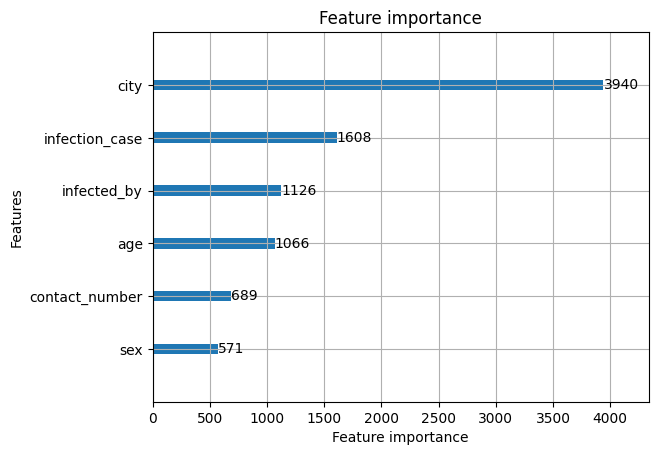

In [ ]:
from lightgbm import plot_importance
plot_importance(lgbm)
pyplot.show()

#Hyperparameter Tunning LGBM

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

optimized_lgbm = lgbm.LGBMRegressor()                                                            
optimized_lgbm.fit(X_train, Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
param = {
        'n_estimators': (100, 400, 10),
        'min_child_weight': (3, 20, 2),
        'colsample_bytree': (0.4, 1.0),
        'max_depth': (5, 15, 2),
        'min_child_samples': (10, 30)}
        
grid = GridSearchCV(optimized_lgbm, param_grid = param, cv=5)

grid.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': (0.4, 1.0),
                         'max_depth': (5, 15, 2), 'min_child_samples': (10, 30),
                         'min_child_weight

In [ ]:
predicted1 = grid.predict(X_test)
predicted1
X_test.shape

(1033, 6)

              precision    recall  f1-score   support

           0       0.42      0.50      0.45        10
           1       0.87      0.84      0.86       435
           2       0.89      0.90      0.89       588

    accuracy                           0.87      1033
   macro avg       0.72      0.75      0.74      1033
weighted avg       0.87      0.87      0.87      1033

[[  5   1   4]
 [  3 367  65]
 [  4  53 531]]
Accuracy Light Gradient Boosting after tuning: 82.6720135078092
ROC AUC score LGBM: 95.4218248537189
Recall of LGBM is after tuning:  87.41529525653436
Precision of LGBM is after tuning: 87.41529525653436
Confusion Matrix : 
 AxesSubplot(0.125,0.11;0.62x0.77)


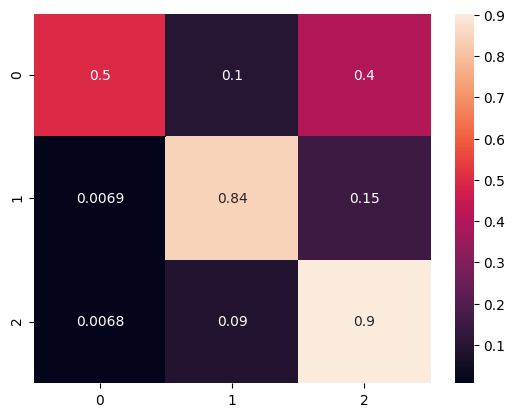

In [ ]:
lgbm_tuning = LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0)
lgbm_tuning.fit(X_train, Y_train)
predicted = lgbm_tuning.predict(X_test)
report = classification_report(Y_test, predicted)
matrix = confusion_matrix(Y_test, predicted)
print(report)
print(matrix)

akurasi_lgbm = cross_val_score(lgbm_tuning, X_test, Y_test, cv=seed, scoring='accuracy') *100

from sklearn.metrics import roc_auc_score

print("Accuracy Light Gradient Boosting after tuning: {}".format((akurasi_lgbm.mean()))) 
auc_lgbm = roc_auc_score(Y_test, lgbm_tuning.predict_proba(X_test), multi_class='ovo',  average='weighted') *100
print('ROC AUC score LGBM:', auc_lgbm)

recall_lgbm=recall_score(Y_test,predicted, average='micro')*100
print("Recall of LGBM is after tuning: ",recall_lgbm)
prec_lgbm=precision_score(Y_test,predicted, average='micro')*100
print("Precision of LGBM is after tuning:",prec_lgbm)

print ("Confusion Matrix : \n",sns.heatmap(confusion_matrix(Y_test, predicted, normalize='true'), annot = True))